# Create Classifier

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

%aimport deepsvr

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%matplotlib inline

In [4]:
import numpy as np
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_predict
# from sklearn import preprocessing
from sklearn import metrics
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from analysis_utils.ClassifierPlots import create_reliability_diagram, create_roc_curve, create_feature_importance_plot, make_model_output_plot
from analysis_utils.Analysis import determine_feature_importance, print_accuracy_and_classification_report, predict_classes, get_somatic_error_type, calculate_kappa

sns.set_style("white")
sns.set_context('talk')

Using TensorFlow backend.


# Create Classifier

In [5]:
# Pull in training data
training_data = pd.read_pickle('../data/training_data.pkl')

In [6]:
# Fix random seed for reproducibility
# seed = 7
# np.random.seed(seed)

# Set parameters for cross-validation fold splits
# kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

# Re-label the germline calls as failed calls
three_class = training_data.replace('g','f')
three_class.sort_index(axis=1, inplace=True)

In [7]:
##### Maybe create a preprocessed and processed training data pkl

# Remove disease labels
s_v_b = three_class
s_v_b['solid_tumor'] = s_v_b[['disease_GST', 'disease_MPNST', 'disease_SCLC',
                              'disease_breast', 'disease_colorectal', 
                              'disease_glioblastoma', 'disease_melanoma']].apply(any, axis=1).astype(int)
s_v_b.drop(['disease_AML', 'disease_GST', 'disease_MPNST', 'disease_SCLC',
       'disease_breast', 'disease_colorectal', 'disease_glioblastoma',
       'disease_lymphoma', 'disease_melanoma'], axis=1, inplace=True)

In [8]:
# Get Labels
Y = pd.get_dummies(three_class.call).astype(float).values
# Get training data as numpy array, remove reviews because of non overlap
s_v_b = s_v_b.drop(['call', 'reviewer_1',
                'reviewer_2', 'reviewer_3', 
                'reviewer_4'], axis=1)
X = s_v_b.sort_index(axis=1).astype(float).values

In [9]:
# define baseline model
def model():
    # create model
    model = Sequential()
    model.add(Dense(59, input_dim=59, kernel_initializer='normal', activation='tanh', kernel_regularizer=l2(0.01)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.01)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.01)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.01)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.01)))
    model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [10]:
estimator = KerasClassifier(build_fn=model, epochs=1000, batch_size=2000, verbose=0)

In [11]:
estimator.fit(X, Y)

# TCGA Analysis

In [22]:
pd.read_pickle(input_data[0][0]

[['../data/orthogonal_test/TCGA-05-4396-01A-21D-1855-08_TCGA-05-4396-10A-01D-1855-08_LUAD/call.pkl',
  '../data/orthogonal_test/TCGA-05-4396-01A-21D-1855-08_TCGA-05-4396-10A-01D-1855-08_LUAD/train.pkl',
  1,
  ['reviewer_N/A', 'disease_LUAD']],
 ['../data/orthogonal_test/TCGA-2H-A9GH-01A-11D-A37C-09_TCGA-2H-A9GH-11A-11D-A37F-09_ESCA/call.pkl',
  '../data/orthogonal_test/TCGA-2H-A9GH-01A-11D-A37C-09_TCGA-2H-A9GH-11A-11D-A37F-09_ESCA/train.pkl',
  1,
  ['reviewer_N/A', 'disease_ESCA']],
 ['../data/orthogonal_test/TCGA-2H-A9GI-01A-11D-A37C-09_TCGA-2H-A9GI-11A-11D-A37F-09_ESCA/call.pkl',
  '../data/orthogonal_test/TCGA-2H-A9GI-01A-11D-A37C-09_TCGA-2H-A9GI-11A-11D-A37F-09_ESCA/train.pkl',
  1,
  ['reviewer_N/A', 'disease_ESCA']],
 ['../data/orthogonal_test/TCGA-2W-A8YY-01A-11D-A37N-09_TCGA-2W-A8YY-10A-01D-A37N-09_CESC/call.pkl',
  '../data/orthogonal_test/TCGA-2W-A8YY-01A-11D-A37N-09_TCGA-2W-A8YY-10A-01D-A37N-09_CESC/train.pkl',
  1,
  ['reviewer_N/A', 'disease_CESC']],
 ['../data/orthogona

In [12]:
def sensitivity(training_data_path, calls_path, tumor_type,
                cols_to_drop):
    data = pd.read_pickle(training_data_path)
    data['solid_tumor'] = 1
    call = pd.read_pickle(calls_path)
    call = call.map(str.lower).replace('g','f').replace('s\x03', 's')

    # # Get Labels
    Y = pd.get_dummies(call)
    Y['a'] = 0
    Y = Y[['a', 'f', 's']].astype(float).values


    # # Get training data as numpy array
    X = data.sort_index(axis=1).drop(cols_to_drop, axis=1).astype(float).values

    probs = estimator.predict_proba(X)

    tumor_df = pd.DataFrame(probs, columns=['ambiguous', 'fail', 'somatic'])
    tumor_df['call'] = call
    
    total_sen = 0
    total_spec = 0
    count_sen = 0
    count_spec = 0
    for index, row in tumor_df.iterrows():
        if row[3] == 's':
            total_sen += 1
        if row[3] == 'f':
            total_spec += 1
        if row[3] == 's' and row[0:3].idxmax() == 'somatic':
            count_sen += 1
        if row[3] == 's' and row[0:3].idxmax() == 'ambiguous':
            count_sen +=1
        if row[3] == 'f' and row[0:3].idxmax() == 'fail':
            count_spec +=1
            
    sensitivity = count_sen/total_sen*100
    specificity = count_spec/total_spec*100
    if sensitivity == 0:
        print(sensitivity)
        print(calls_path)
    return sensitivity, specificity

In [16]:
count_directory = {'ESCA':[0,0,0],'THYM': [0,0,0],
                    'CHOL': [0,0,0], 'LUAD': [0,0,0],
                    'BRCA': [0,0,0], 'UCEC': [0,0,0],
                    'LIHC': [0,0,0], 'CESC': [0,0,0]}

accuracy_matrix = []
data = []
input_data = []

import glob
for item in glob.glob('../data/orthogonal_test/*/'):
    data.append(glob.glob(item + '*.pkl'))

for item in data:
    train = item[0]
    call = item[1]
    disease = item[0].split('_')[3].split('/')[0]
    types = 1
    drop = ['reviewer_N/A', 'disease_' + disease]
    input_data.append([train, call, types, drop])

for item in input_data:
    sen, spec = sensitivity(item[1], item[0], item[2], item[3])
    disease = item[3][1].split('_')[1]
    count_directory[disease][0] += 1
    count_directory[disease][1] += pd.read_pickle(item[0]).value_counts()['F']
    count_directory[disease][2] += pd.read_pickle(item[0]).value_counts()['S']
    
    accuracy_matrix.append([disease, sen, 'Sensitivity'])
    accuracy_matrix.append([disease, spec, 'Specificity'])


0.0
../data/orthogonal_test/TCGA-ZC-AAA7-01A-11D-A428-09_TCGA-ZC-AAA7-10A-01D-A42B-09_THYM/call.pkl


In [18]:
count_directory_df = pd.DataFrame(count_directory, index = ['Tumors', 'FP', 'TP'])

In [19]:
labels = []
for key,item in sorted(count_directory.items()):
    tumor = key
    tumor_count = str(item[0])
    FP = str(item[1])
    TP = str(item [2])
    labels.append(tumor + ' = ' + tumor_count + '\n' + 'TP = ' +TP + '\n' + 'FP = ' +FP)

In [20]:
accuracy_df = pd.DataFrame(accuracy_matrix, columns=['Tumor Type', 'Accuracy', 'Type'])

# Figure Parsed by Sensitivity/Specificity

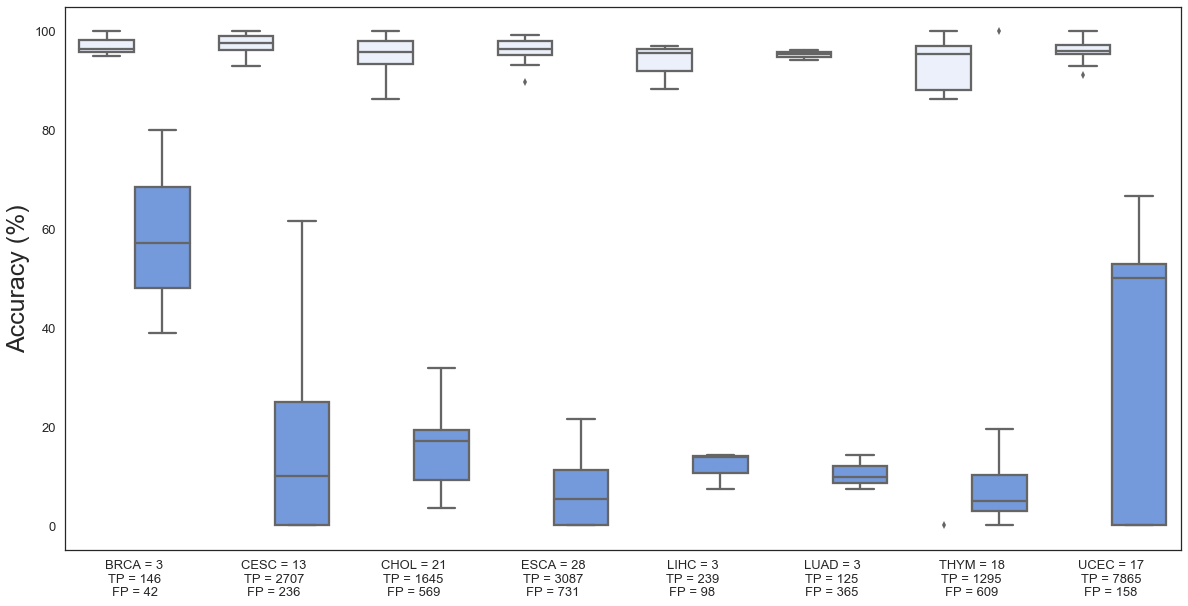

In [21]:
sns.set_style("white")
sns.set_context('talk')
# sns.set(font_scale = 2)
fig, ax = plt.subplots(1, 1)
ax = sns.boxplot(x="Tumor Type", y="Accuracy", hue='Type', data=accuracy_df, order=sorted(count_directory_df), color = 'cornflowerblue')
ax.set_xticklabels(labels)
ax.legend('')
ax.set_ylabel('Accuracy (%)', fontsize=25)
ax.set_xlabel('', fontsize=25)
ax.set_title('', fontsize=25)
fig.set_size_inches(20, 10)
plt.show()
# fig.savefig('../../Desktop/orthogonal_validation/TCGA_Validation.png', bbox_inches='tight', dpi=100)

# ROC Curve Analysis

In [21]:

def roc_curve(Y, probabilities, class_lookup):
    '''Create ROC curve to compare multiclass model performance.

    Parameters:
        Y (numpy.array): Truth labels
        probabilities (numpy.array): Output of model for each class
        class_lookup (dict): lookup hash of truth labels
        title (str): Plot title
    '''
    fpr, tpr, _ = metrics.roc_curve(Y['somatic'], probabilities['somatic'])
    roc_auc = metrics.auc(fpr, tpr)

    return roc_auc, fpr, tpr
    
def determine_independent_test_performance(training_data_path,
                                          calls_path, tumor_type,
                                          cols_to_drop, 
                                          estimator, name):
    data = pd.read_pickle(training_data_path)
    data['solid_tumor'] = tumor_type
    call = pd.read_pickle(calls_path)
    call=call.map(str.lower).replace('g','f').replace('s\x03', 's').replace('', 'f')
    # Get Labels
    Y = pd.get_dummies(call)
    Y['a'] = 0
    Y = Y[['a', 'f', 's']].astype(float).values
    
    # Get training data as numpy array
    X = data.sort_index(axis=1).drop(cols_to_drop, axis=1).astype(float).values

    probs = estimator.predict_proba(X)
    probs = pd.DataFrame(probs, columns=['amb', 'fail', 'somatic'])
    Y = pd.DataFrame(Y, columns=['amb', 'fail', 'somatic'])
    class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
    roc_auc, fpr, tpr = roc_curve(Y, probs, class_lookup)
    AUC_directory[name.split('_')[2]].append(roc_auc)



In [53]:
AUC_directory = {'ESCA':[],'THYM': [],
                    'CHOL': [], 'LUAD': [],
                    'BRCA': [], 'UCEC': [],
                    'LIHC': [], 'CESC': []}

for item in input_data:
    determine_independent_test_performance(item[0], item[1], item[2], 
                                           item[3], estimator, str(item[0].split('/')[3]))
    

In [54]:
fixed_data = []
for key, item in sorted(AUC_directory.items()):
    fixed_data.append(item)


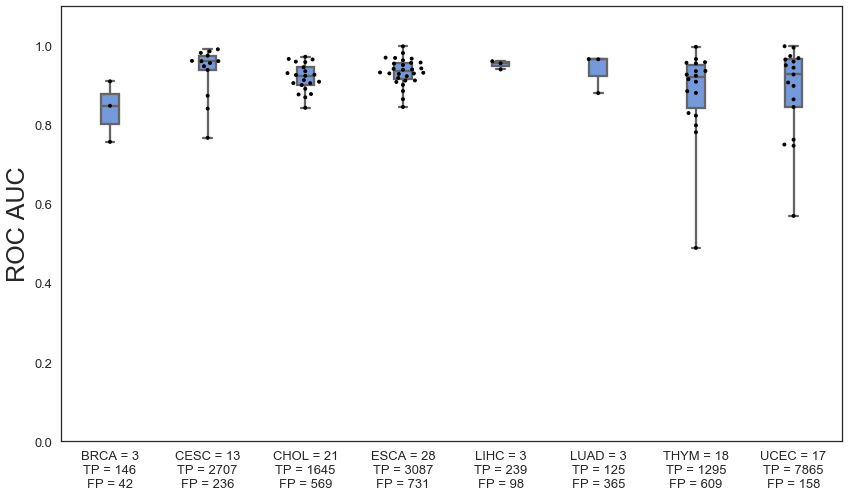

In [123]:
sns.set_style("white")
sns.set_context('talk')

fig, ax = plt.subplots(1, 1)

sns.boxplot(data=fixed_data, whis=np.inf, width=.18, color='cornflowerblue')
sns.swarmplot(data=fixed_data, size=3, edgecolor="black", linewidth=.9, color = 'black')
ax.set_ylim(0,1.1)
ax.set_xticklabels(labels)
ax.legend('')
ax.set_ylabel('ROC AUC', fontsize=25)
ax.set_xlabel('', fontsize=25)
ax.set_title('', fontsize=25)
fig.set_size_inches(14, 8)
plt.show()
fig.savefig('../../Desktop/orthogonal_validation/TCGA_Validation_AUC.png', bbox_inches='tight', dpi=100)

# Retraining Analysis 

In [126]:
def calculate_retraining_improvement(independent_test_X, independent_test_Y,
                                    X, Y, estimator, random_seed):
    auc = []
    for i in np.arange(0, 0.8, 0.05):
        if i == 0:
            independent_test_X_test = independent_test_X
            independent_test_Y_test = independent_test_Y
            X_train = X
            Y_train = Y
        else:
            (independent_test_X_train, 
             independent_test_X_test, 
             independent_test_Y_train, 
             independent_test_Y_test) = train_test_split(independent_test_X, 
                                                         independent_test_Y,
                                                         train_size=i,
                                                         random_state=seed,
                                                         stratify=\
                                                         independent_test_Y) 
            X_train = np.concatenate((X, independent_test_X_train))
            Y_train = np.concatenate((Y, independent_test_Y_train))
        print('Percentage of test data included in training: ', i*100)
        print('Training data shape: ', X_train.shape)
        print('Test data shape: ', independent_test_X_test.shape)
        print('Number of test samples included in training: ', 
              X_train.shape[0]-X.shape[0])
        estimator.fit(X_train, Y_train)
        X_test_probs = estimator.predict_proba(independent_test_X_test)
        print_accuracy_and_classification_report(independent_test_Y_test, 
                                                 predict_classes(X_test_probs))
        
        X_test_probs = pd.DataFrame(X_test_probs, columns=['amb', 'fail', 'somatic'])
        independent_test_Y_test = pd.DataFrame(independent_test_Y_test, columns=['amb', 'fail', 'somatic'])
        class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
        
        roc_auc, fpr, tpr = roc_curve(independent_test_Y_test, X_test_probs, class_lookup)
        auc.append([X_train.shape[0]-X.shape[0], roc_auc])
        print('Test AUC: ', roc_auc)
        print('---------------------------------------------------------')
    return auc

def create_batch_effect_retraining_figure(auc, fig_out_name):
    auc = pd.DataFrame(auc, columns=['num. variants in training', 'somatic'])
    fig, ax = plt.subplots(1, 1)
    auc.plot(x='num. variants in training', y='somatic', ax=ax, 
                  color='black')
    ax.plot([0, auc['num. variants in training'].max()],
            [.96,.96], linestyle='--', dashes=(5, 5),color='black', 
            label='somatic cross validation')
    ax.legend(loc=4,frameon=True)
    ax.set_ylim([0,1.0])
    ax.set_ylabel('AUC Attained After Re-Training', fontsize=22)
    ax.set_xlabel('Number of Variants used to Re-Train the Model', fontsize=22)
    ax.set_title('TCGA - Re-Training Analysis', fontsize=24)
    fig.set_size_inches(10, 8)
    savefig('/Users/ebarnell/Desktop/orthogonal_validation/'+ fig_out_name +'_Retrain.png', bbox_inches='tight', dpi=100)

In [26]:
call_combined = pd.DataFrame()
train_combined = pd.DataFrame()
for item in input_data:
    training_data_path = item[0]
    data = pd.read_pickle(training_data_path)
    data = data.drop(data.columns[0:2], axis=1)
    data['solid_tumor'] = 1
    train_combined = train_combined.append(data)
    calls_path = item[1]
    call = pd.read_pickle(calls_path)
    call = call.map(str.lower).replace('g','f').replace('s\x03', 's')
    call = pd.DataFrame(call)

    call_combined = call_combined.append(call)

call_combined = call_combined['call'].map(str.lower).replace('g','f').replace('s\x03', 's').replace('', 'f')

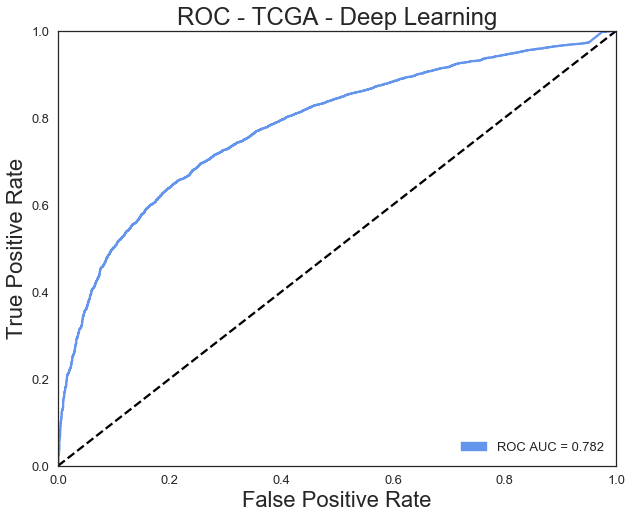

In [112]:
sns.set_style("white")
sns.set_context('talk')

data = train_combined

# Get Labels
TCGA_Y_initial = pd.get_dummies(call_combined)
TCGA_Y_initial['a'] = 0
TCGA_Y_initial = TCGA_Y_initial[['a', 'f', 's']].astype(float).values

# Get training data as numpy array
TCGA_X_initial = data.sort_index(axis=1).astype(float).values

probs_initial = estimator.predict_proba(TCGA_X_initial)
probs_initial = pd.DataFrame(probs_initial, columns=['amb', 'fail', 'somatic'])
TCGA_Y_initial = pd.DataFrame(TCGA_Y_initial, columns=['amb', 'fail', 'somatic'])
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
roc_auc_initial, fpr_initial, tpr_initial = roc_curve(TCGA_Y_initial, probs_initial, class_lookup)

import matplotlib.patches as mpatches

fig, ax = plt.subplots()
ax.plot(fpr_initial, tpr_initial, color='cornflowerblue')

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

blue_patch = mpatches.Patch(color='cornflowerblue', label='ROC AUC = ' + str(round(roc_auc_initial, 3)))
plt.legend(handles=[blue_patch], loc="lower right")


ax.set_ylabel('True Positive Rate', fontsize=22)
ax.set_xlabel('False Positive Rate', fontsize=22)
ax.set_title('ROC - TCGA - Deep Learning', fontsize=24)
fig.set_size_inches(10, 8)
savefig('/Users/ebarnell/Desktop/orthogonal_validation/TCGA_ROC.png', bbox_inches='tight', dpi=100)

In [32]:
# TCGA_auc = calculate_retraining_improvement(TCGA_X_initial, TCGA_Y_initial, X, Y, estimator, 7)

Percentage of test data included in training:  0.0
Training data shape:  (41832, 59)
Test data shape:  (19917, 59)
Number of test samples included in training:  0
Cross validation accuracy:
	 0.824622182056

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.36      0.14      0.20      2808
          2       0.88      0.94      0.91     17109

avg / total       0.81      0.82      0.81     19917

Test AUC:  0.785878427558
---------------------------------------------------------


/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Percentage of test data included in training:  5.0
Training data shape:  (42827, 59)
Test data shape:  (18922, 59)
Number of test samples included in training:  995
Cross validation accuracy:
	 0.821107705317

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.39      0.16      0.23      2668
          2       0.90      0.93      0.91     16254

avg / total       0.83      0.82      0.82     18922

Test AUC:  0.852013177612
---------------------------------------------------------
Percentage of test data included in training:  10.0
Training data shape:  (43823, 59)
Test data shape:  (17926, 59)
Number of test samples included in training:  1991
Cross validation accuracy:
	 0.81652348544

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.42      0.18      0.

Percentage of test data included in training:  75.0
Training data shape:  (56769, 59)
Test data shape:  (4980, 59)
Number of test samples included in training:  14937
Cross validation accuracy:
	 0.848393574297

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.81      0.33      0.47       702
          2       0.94      0.93      0.94      4278

avg / total       0.92      0.85      0.87      4980

Test AUC:  0.925794397627
---------------------------------------------------------


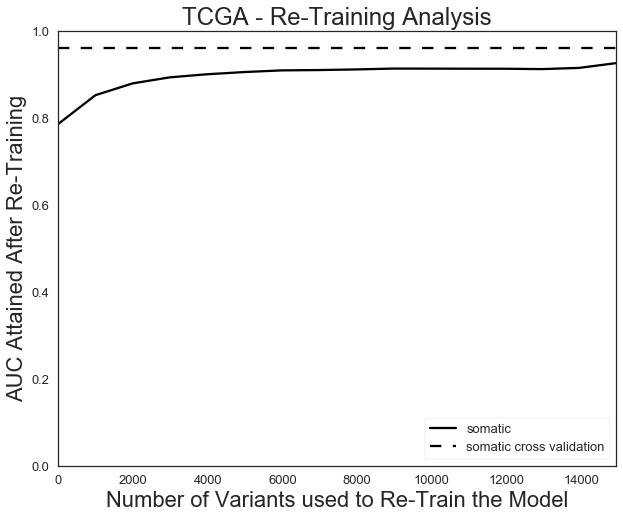

In [127]:
create_batch_effect_retraining_figure(TCGA_auc, 'TCGA_orthogonal_validation')

# Create ROC Curves for Each tumor Subtype

In [74]:
def combine_pkls(disease, input_data):
    call_combined = pd.DataFrame()
    train_combined = pd.DataFrame()
    for item in input_data:
        if disease in item[3]:
            training_data_path = item[0]
            data = pd.read_pickle(training_data_path)
            data = data.drop(data.columns[0:2], axis=1)
            data['solid_tumor'] = 1
            train_combined = train_combined.append(data)
            calls_path = item[1]
            call = pd.read_pickle(calls_path)
            call = call.map(str.lower).replace('g','f').replace('s\x03', 's')
            call = pd.DataFrame(call)

            call_combined = call_combined.append(call)

    call_combined = call_combined['call'].map(str.lower).replace('g','f').replace('s\x03', 's').replace('', 'f')
    return call_combined, train_combined

In [77]:
call_ESCA, train_ESCA = combine_pkls('disease_ESCA', input_data)
call_THYM, train_THYM = combine_pkls('disease_THYM', input_data)
call_CHOL, train_CHOL = combine_pkls('disease_CHOL', input_data)
call_BRCA, train_BRCA = combine_pkls('disease_BRCA', input_data)
call_LIHC, train_LIHC = combine_pkls('disease_LIHC', input_data)
call_LUAD, train_LUAD = combine_pkls('disease_LUAD', input_data)
call_UCEC, train_UCEC = combine_pkls('disease_UCEC', input_data)
call_CESC, train_CESC = combine_pkls('disease_CESC', input_data)

In [83]:
def generate_ROC_curve(call_combined, train_combined, disease):
    data = train_combined

    # Get Labels
    TCGA_Y_initial = pd.get_dummies(call_combined)
    TCGA_Y_initial['a'] = 0
    TCGA_Y_initial = TCGA_Y_initial[['a', 'f', 's']].astype(float).values

    # Get training data as numpy array
    TCGA_X_initial = data.sort_index(axis=1).astype(float).values

    probs_initial = estimator.predict_proba(TCGA_X_initial)
    probs_initial = pd.DataFrame(probs_initial, columns=['amb', 'fail', 'somatic'])
    TCGA_Y_initial = pd.DataFrame(TCGA_Y_initial, columns=['amb', 'fail', 'somatic'])
    class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
    roc_auc_initial, fpr_initial, tpr_initial = roc_curve(TCGA_Y_initial, probs_initial, class_lookup)

    import matplotlib.patches as mpatches

    fig, ax = plt.subplots()
    ax.plot(fpr_initial, tpr_initial, color='cornflowerblue')

    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

    blue_patch = mpatches.Patch(color='cornflowerblue', label='ROC AUC = ' + str(round(roc_auc_initial, 3)))
    plt.legend(handles=[blue_patch], loc="lower right")


    ax.set_ylabel('True Positive Rate', fontsize=22)
    ax.set_xlabel('False Positive Rate', fontsize=22)
    ax.set_title('ROC - TCGA - ' + disease + ' - Deep Learning', fontsize=24)
    fig.set_size_inches(10, 8)
    savefig('/Users/ebarnell/Desktop/orthogonal_validation/TCGA_' + disease + '_ROC.png', bbox_inches='tight', dpi=100)

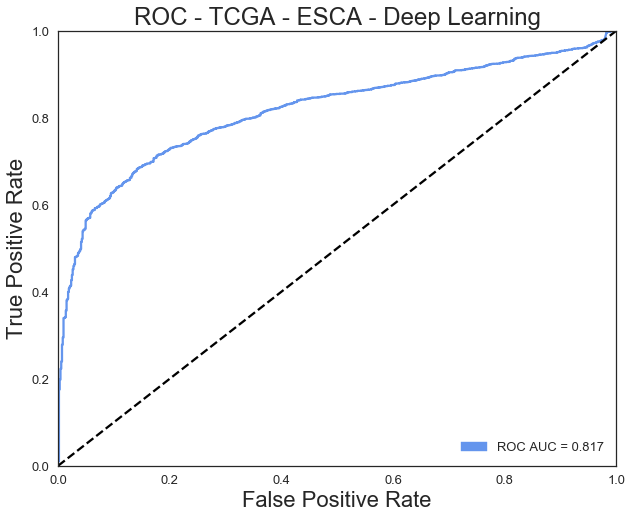

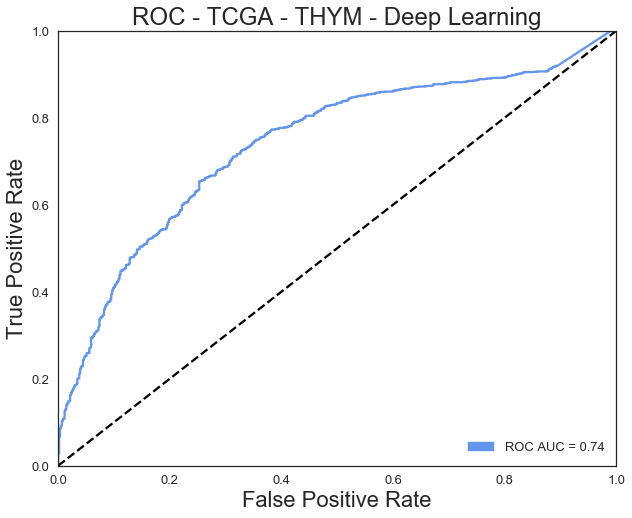

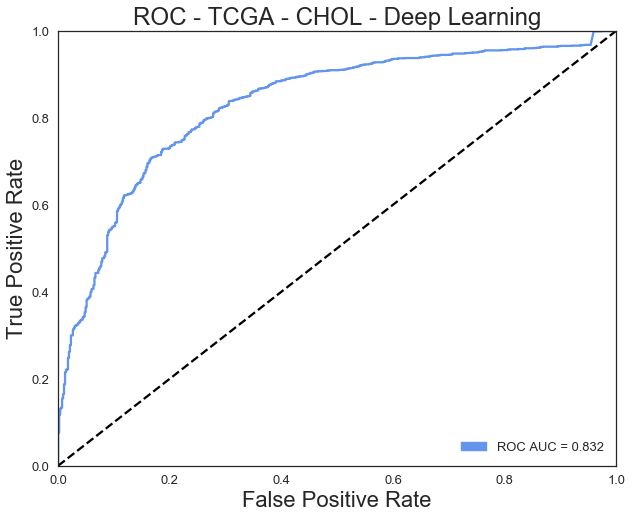

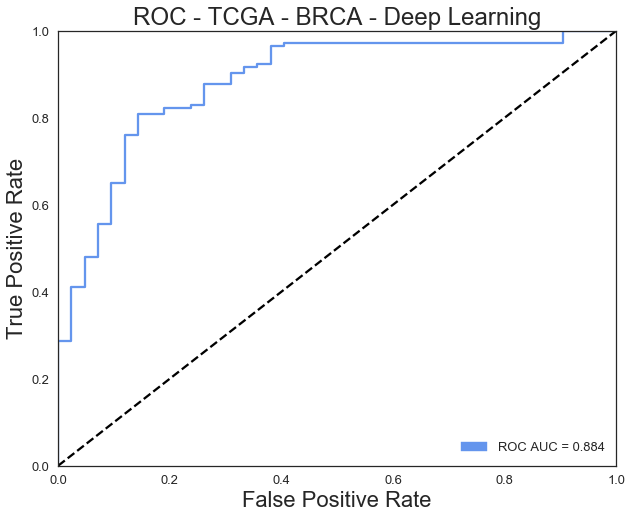

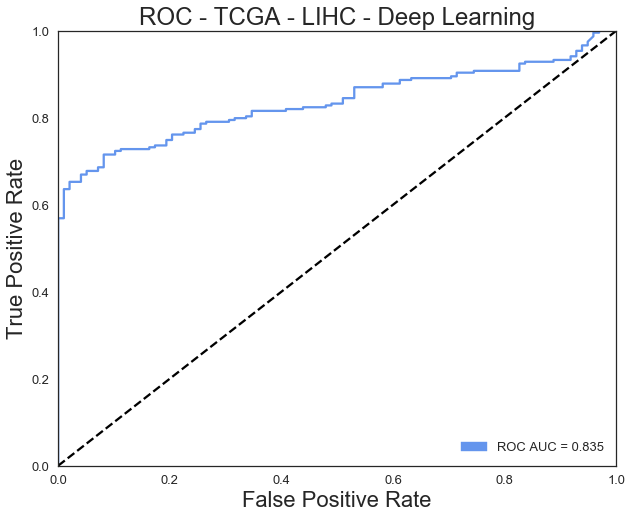

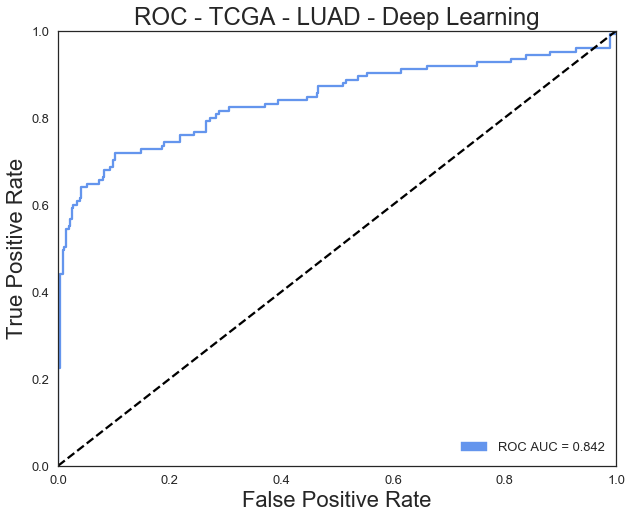

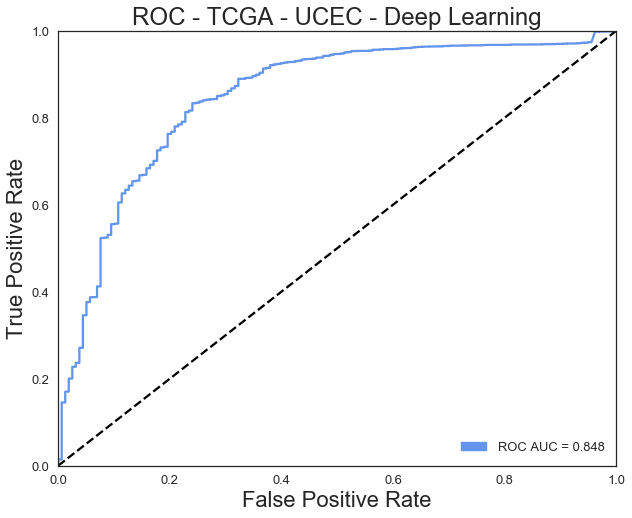

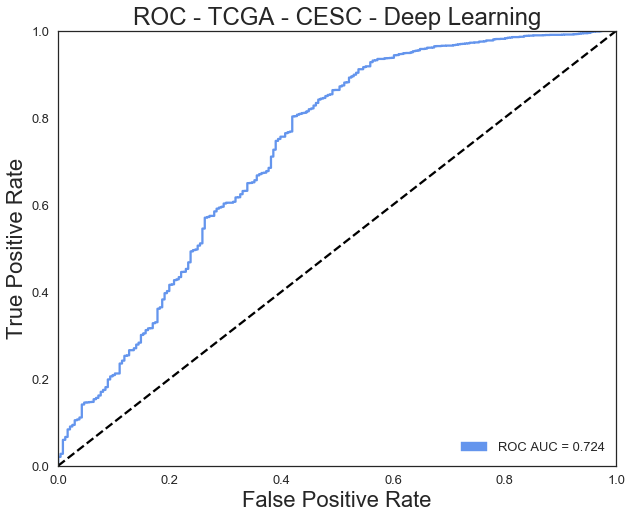

In [114]:
generate_ROC_curve(call_ESCA, train_ESCA, 'ESCA')
generate_ROC_curve(call_THYM, train_THYM, 'THYM')
generate_ROC_curve(call_CHOL, train_CHOL, 'CHOL')
generate_ROC_curve(call_BRCA, train_BRCA, 'BRCA')
generate_ROC_curve(call_LIHC, train_LIHC, 'LIHC')
generate_ROC_curve(call_LUAD, train_LUAD, 'LUAD')
generate_ROC_curve(call_UCEC, train_UCEC, 'UCEC')
generate_ROC_curve(call_CESC, train_CESC, 'CESC')

# Retrain for each tumor subtype

In [92]:
# def calculate_retraining_improvement_individual(call, train,
#                                     X, Y, estimator, random_seed):
#     data = train

#     # Get Labels
#     TCGA_Y_initial = pd.get_dummies(call)
#     TCGA_Y_initial['a'] = 0
#     TCGA_Y_initial = TCGA_Y_initial[['a', 'f', 's']].astype(float).values

#     # Get training data as numpy array
#     independent_test_X = data.sort_index(axis=1).astype(float).values

#     probs_initial = estimator.predict_proba(TCGA_X_initial)
#     probs_initial = pd.DataFrame(probs_initial, columns=['amb', 'fail', 'somatic'])
#     independent_test_Y = pd.DataFrame(TCGA_Y_initial, columns=['amb', 'fail', 'somatic'])
    
#     auc = []
#     for i in np.arange(0, 0.8, 0.05):
#         if i == 0:
#             independent_test_X_test = independent_test_X
#             independent_test_Y_test = independent_test_Y
#             X_train = X
#             Y_train = Y
#         else:
#             (independent_test_X_train, 
#              independent_test_X_test, 
#              independent_test_Y_train, 
#              independent_test_Y_test) = train_test_split(independent_test_X, 
#                                                          independent_test_Y,
#                                                          train_size=i,
#                                                          random_state=seed,
#                                                          stratify=\
#                                                          independent_test_Y) 
#             X_train = np.concatenate((X, independent_test_X_train))
#             Y_train = np.concatenate((Y, independent_test_Y_train))
#         print('Percentage of test data included in training: ', i*100)
#         print('Training data shape: ', X_train.shape)
#         print('Test data shape: ', independent_test_X_test.shape)
#         print('Number of test samples included in training: ', 
#               X_train.shape[0]-X.shape[0])
#         estimator.fit(X_train, Y_train)
#         X_test_probs = estimator.predict_proba(independent_test_X_test)
#         print_accuracy_and_classification_report(independent_test_Y_test, 
#                                                  predict_classes(X_test_probs))
        
#         X_test_probs = pd.DataFrame(X_test_probs, columns=['amb', 'fail', 'somatic'])
#         independent_test_Y_test = pd.DataFrame(independent_test_Y_test, columns=['amb', 'fail', 'somatic'])
#         class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
        
#         roc_auc, fpr, tpr = roc_curve(independent_test_Y_test, X_test_probs, class_lookup)
#         auc.append([X_train.shape[0]-X.shape[0], roc_auc])
#         print('Test AUC: ', roc_auc)
#         print('---------------------------------------------------------')
#     return auc

In [94]:
# ESCA_auc = calculate_retraining_improvement_individual(call_ESCA, train_ESCA, X, Y, estimator, 7)

In [95]:
# create_batch_effect_retraining_figure(ESCA_auc, 'ESCA_TCGA_orthogonal_validation')

In [ ]:
# THYM_auc = calculate_retraining_improvement_individual(call_THYM, train_THYM, X, Y, estimator, 7)
# CHOL_auc = calculate_retraining_improvement_individual(call_CHOL, train_CHOL, X, Y, estimator, 7)
# BRCA_auc = calculate_retraining_improvement_individual(call_BRCA, train_BRCA, X, Y, estimator, 7)
# LIHC_auc = calculate_retraining_improvement_individual(call_LIHC, train_LIHC, X, Y, estimator, 7)
# LUAD_auc = calculate_retraining_improvement_individual(call_LUAD, train_LUAD, X, Y, estimator, 7)
# UCEC_auc = calculate_retraining_improvement_individual(call_UCEC, train_UCEC, X, Y, estimator, 7)
# CESC_auc = calculate_retraining_improvement_individual(call_CESC, train_CESC, X, Y, estimator, 7)